In [297]:
# generative model
from src.SlovotvirModelM import run_model_parallel

# bayesflow components
import bayesflow.diagnostics as diag

# helpher functions
from src.helpers import (generate_latex_table,
                         binning,
                         plot_posterior,
                         train_and_amortize, 
                         letter_subplots)

# other
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [298]:
RNG = np.random.default_rng(2023)

## Inference of all 3 parameters

In [299]:
train_size = 100000
test_size = 10000
valid_size = 10000

### 1. Generating training and testing data

In [300]:
# training_params = (np.random.uniform(0, 10, train_size), np.random.uniform(0, 10, train_size), np.random.lognormal(0, 0.5, train_size))
# testing_params = (np.random.uniform(0, 10, test_size), np.random.uniform(0, 10, test_size), np.random.lognormal(0, 0.5, test_size))
# validation_params = (np.random.uniform(0, 10, valid_size), np.random.uniform(0, 10, valid_size), np.random.lognormal(0, 0.5, valid_size))

In [301]:
# training_data = run_model_parallel(training_params[0], training_params[1], training_params[2], train_size)

In [302]:
# testing_data = run_model_parallel(testing_params[0], testing_params[1], testing_params[2], test_size)

In [303]:
# validation_data = run_model_parallel(validation_params[0], validation_params[1], validation_params[2], valid_size)

In [304]:
# training_params = np.vstack(training_params)
# testing_params = np.vstack(testing_params)
# validation_params = np.vstack(validation_params)

In [305]:
# train_data = {}
# train_data["prior_non_batchable_context"] = None
# train_data["prior_batchable_context"] = None
# train_data["prior_draws"] = training_params.reshape(3, train_size).T
# train_data["sim_non_batchable_context"] = None
# train_data["sim_batchable_context"] = None
# train_data["sim_data"] = np.array(training_data, dtype = float)


# test_data = {}
# test_data["prior_non_batchable_context"] = None
# test_data["prior_batchable_context"] = None
# test_data["prior_draws"] = testing_params.reshape(3, test_size).T
# test_data["sim_non_batchable_context"] = None
# test_data["sim_batchable_context"] = None
# test_data["sim_data"] = np.array(testing_data, dtype = float)

# valid_data = {}
# valid_data["prior_non_batchable_context"] = None
# valid_data["prior_batchable_context"] = None
# valid_data["prior_draws"] = validation_params.reshape(3, valid_size).T
# valid_data["sim_non_batchable_context"] = None
# valid_data["sim_batchable_context"] = None
# valid_data["sim_data"] = np.array(validation_data, dtype = float)

In [220]:
# pickle.dump(train_data, open("data/train_data_1605.pkl", "wb"))
# pickle.dump(test_data, open("data/test_data_1605.pkl", "wb"))
# pickle.dump(valid_data, open("data/valid_data_1605.pkl", "wb"))
# load data
train_data = pickle.load(open("data/train_data_1405.pkl", "rb"))
test_data = pickle.load(open("data/test_data_1405.pkl", "rb"))
valid_data = pickle.load(open("data/valid_data_1405.pkl", "rb"))

train_data_ = pickle.load(open("data/train_data_1605.pkl", "rb"))
test_data_ = pickle.load(open("data/test_data_1605.pkl", "rb"))
valid_data_ = pickle.load(open("data/valid_data_1605.pkl", "rb"))

In [222]:
train_data_['sim_data'].shape

(20000, 42044)

In [223]:
train_data_["sim_data"] = np.array(list(map(binning, train_data_["sim_data"])))
test_data_["sim_data"] = np.array(list(map(binning, test_data_["sim_data"])))
valid_data_["sim_data"] = np.array(list(map(binning, valid_data_["sim_data"])))

In [224]:
# combine sim_data and prior_draws
train_data["sim_data"] = np.concatenate((train_data["sim_data"], train_data_["sim_data"]))
train_data["prior_draws"] = np.concatenate((train_data["prior_draws"], train_data_["prior_draws"]))
test_data["sim_data"] = np.concatenate((test_data["sim_data"], test_data_["sim_data"]))
test_data["prior_draws"] = np.concatenate((test_data["prior_draws"], test_data_["prior_draws"]))
valid_data["sim_data"] = np.concatenate((valid_data["sim_data"], valid_data_["sim_data"]))
valid_data["prior_draws"] = np.concatenate((valid_data["prior_draws"], valid_data_["prior_draws"]))

In [225]:
prior_means = np.mean(train_data["prior_draws"], axis=0)
prior_stds = np.std(train_data["prior_draws"], axis=0)

In [226]:
train_data['sim_data'].shape

(100000, 17)

In [227]:
pickle.dump(train_data, open("data/train_data_1705_FINAL.pkl", "wb"))
pickle.dump(test_data, open("data/test_data_1705_FINAL.pkl", "wb"))
pickle.dump(valid_data, open("data/valid_data_1705_FINAL.pkl", "wb"))

### 2. Training the model

In [230]:
num_params = 3
epochs = 300
batch_size = 32
learning_rate = 0.001

In [231]:
history, trainer, amortizer = train_and_amortize(train_data, batch_size, test_data, epochs, 
                                                 num_params, 4, learning_rate, prior_means, prior_stds)

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!


Training epoch 1:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 1.259


Training epoch 2:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 0.913


Training epoch 3:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 0.695


Training epoch 4:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 0.794


Training epoch 5:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 0.896


Training epoch 6:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 0.737


Training epoch 7:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 0.411


Training epoch 8:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Loss: 0.007


Training epoch 9:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Loss: -0.088


Training epoch 10:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Loss: -0.343


Training epoch 11:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Loss: -0.535


Training epoch 12:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Loss: -0.523


Training epoch 13:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Loss: -0.277


Training epoch 14:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Loss: -0.529


Training epoch 15:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Loss: -0.847


Training epoch 16:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Loss: -0.607


Training epoch 17:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Loss: -0.938


Training epoch 18:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Loss: -0.717


Training epoch 19:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Loss: -0.651


Training epoch 20:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Loss: -0.973


Training epoch 21:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Loss: -0.915


Training epoch 22:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Loss: -0.956


Training epoch 23:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Loss: -0.995


Training epoch 24:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Loss: -1.020


Training epoch 25:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, Loss: -0.695


Training epoch 26:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, Loss: -1.020


Training epoch 27:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, Loss: -1.020


Training epoch 28:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, Loss: -0.804


Training epoch 29:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, Loss: -1.189


Training epoch 30:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, Loss: -1.096


Training epoch 31:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 31, Loss: -1.041


Training epoch 32:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 32, Loss: -1.124


Training epoch 33:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 33, Loss: -1.280


Training epoch 34:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 34, Loss: -1.040


Training epoch 35:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 35, Loss: -0.825


Training epoch 36:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 36, Loss: -1.125


Training epoch 37:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 37, Loss: -1.311


Training epoch 38:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 38, Loss: -0.970


Training epoch 39:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 39, Loss: -1.286


Training epoch 40:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 40, Loss: -1.377


Training epoch 41:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 41, Loss: -1.320


Training epoch 42:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 42, Loss: -1.519


Training epoch 43:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 43, Loss: -0.832


Training epoch 44:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 44, Loss: -1.436


Training epoch 45:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 45, Loss: -1.310


Training epoch 46:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 46, Loss: -1.382


Training epoch 47:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 47, Loss: -1.315


Training epoch 48:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 48, Loss: -1.408


Training epoch 49:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 49, Loss: -1.476


Training epoch 50:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 50, Loss: -1.509


Training epoch 51:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 51, Loss: -0.854


Training epoch 52:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 52, Loss: -1.472


Training epoch 53:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 53, Loss: -1.476


Training epoch 54:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 54, Loss: -1.477


Training epoch 55:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 55, Loss: -1.300


Training epoch 56:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 56, Loss: -1.123


Training epoch 57:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 57, Loss: -1.524


Training epoch 58:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 58, Loss: -1.383


Training epoch 59:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 59, Loss: -1.103


Training epoch 60:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 60, Loss: -1.415


Training epoch 61:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 61, Loss: -1.705


Training epoch 62:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 62, Loss: -1.355


Training epoch 63:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 63, Loss: -1.620


Training epoch 64:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 64, Loss: -1.553


Training epoch 65:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 65, Loss: -1.456


Training epoch 66:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 66, Loss: -1.644


Training epoch 67:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 67, Loss: -1.495


Training epoch 68:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 68, Loss: -1.598


Training epoch 69:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 69, Loss: -1.544


Training epoch 70:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 70, Loss: -1.162


Training epoch 71:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 71, Loss: -1.569


Training epoch 72:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 72, Loss: -1.463


Training epoch 73:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 73, Loss: -1.459


Training epoch 74:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 74, Loss: -1.465


Training epoch 75:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 75, Loss: -1.528


Training epoch 76:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 76, Loss: -1.352


Training epoch 77:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 77, Loss: -1.441


Training epoch 78:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 78, Loss: -1.424


Training epoch 79:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 79, Loss: -1.643


Training epoch 80:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 80, Loss: -1.620


Training epoch 81:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 81, Loss: -1.469


Training epoch 82:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 82, Loss: -1.524


Training epoch 83:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 83, Loss: -1.605


Training epoch 84:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 84, Loss: -1.688


Training epoch 85:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 85, Loss: -1.533


Training epoch 86:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 86, Loss: -1.518


Training epoch 87:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 87, Loss: -1.436


Training epoch 88:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 88, Loss: -1.730


Training epoch 89:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 89, Loss: -1.479


Training epoch 90:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 90, Loss: -1.667


Training epoch 91:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 91, Loss: -1.562


Training epoch 92:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 92, Loss: -1.517


Training epoch 93:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 93, Loss: -1.790


Training epoch 94:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 94, Loss: -1.528


Training epoch 95:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 95, Loss: -1.647


Training epoch 96:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 96, Loss: -1.600


Training epoch 97:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 97, Loss: -1.785


Training epoch 98:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 98, Loss: -1.710


Training epoch 99:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 99, Loss: -1.631


Training epoch 100:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 100, Loss: -1.597


Training epoch 101:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 101, Loss: -1.640


Training epoch 102:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 102, Loss: -1.549


Training epoch 103:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 103, Loss: -1.823


Training epoch 104:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 104, Loss: -1.592


Training epoch 105:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 105, Loss: -1.821


Training epoch 106:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 106, Loss: -1.744


Training epoch 107:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 107, Loss: -1.497


Training epoch 108:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 108, Loss: -1.828


Training epoch 109:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 109, Loss: -1.786


Training epoch 110:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 110, Loss: -1.769


Training epoch 111:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 111, Loss: -1.824


Training epoch 112:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 112, Loss: -1.841


Training epoch 113:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 113, Loss: -1.770


Training epoch 114:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 114, Loss: -1.631


Training epoch 115:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 115, Loss: -1.791


Training epoch 116:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 116, Loss: -1.821


Training epoch 117:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 117, Loss: -1.785


Training epoch 118:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 118, Loss: -1.823


Training epoch 119:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 119, Loss: -1.837


Training epoch 120:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 120, Loss: -1.791


Training epoch 121:   0%|          | 0/3125 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 121, Loss: -1.793
INFO:root:Early stopping triggered.


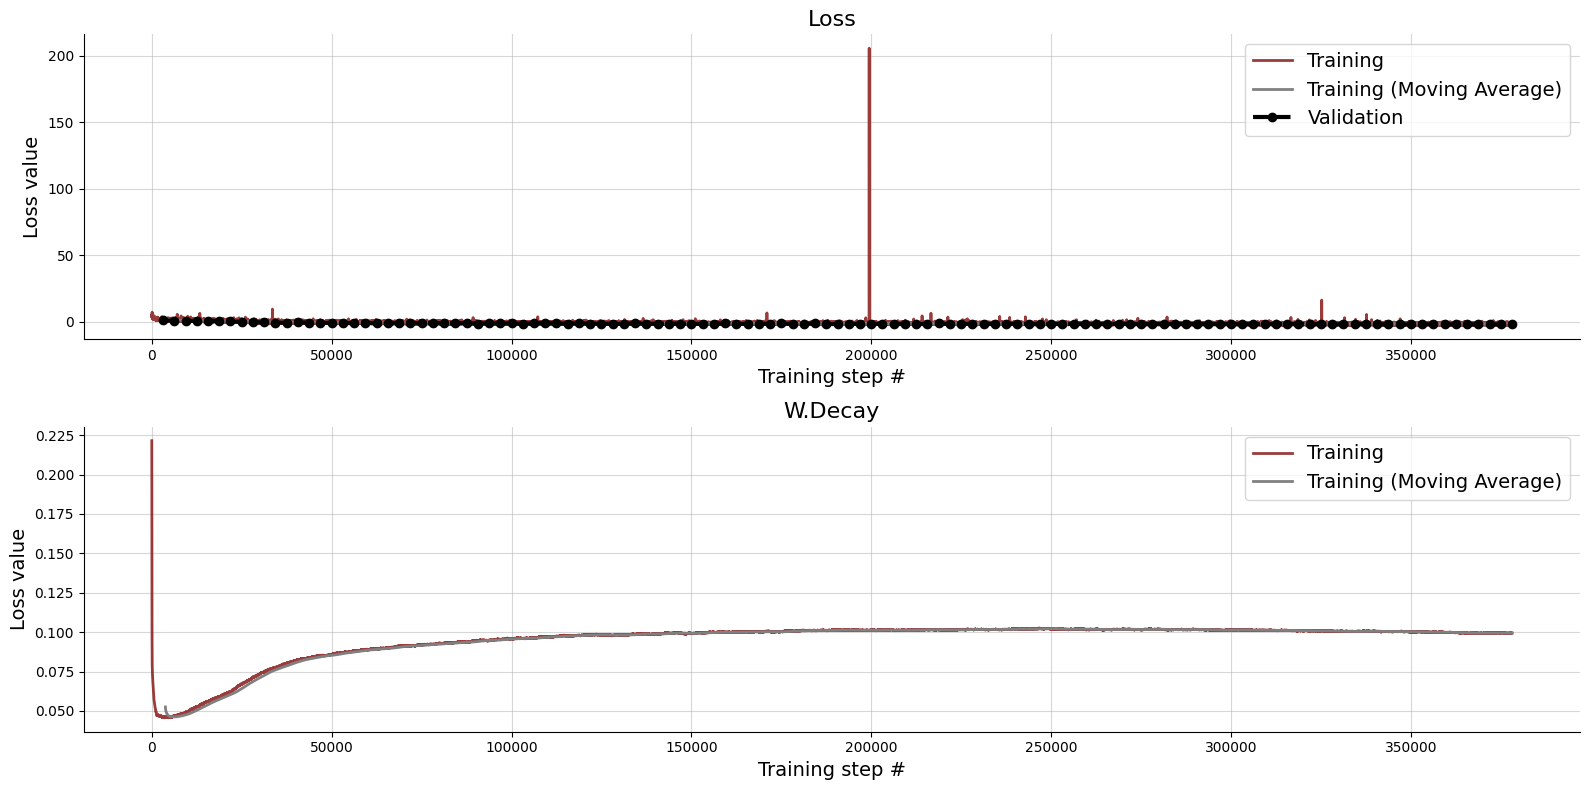

In [232]:
f = diag.plot_losses(history["train_losses"], history["val_losses"], moving_average=True)

### 3. Model analysis

In [306]:
# Generate some validation data
validation_sims = trainer.configurator(valid_data) 
prior_samples = validation_sims["parameters"] * prior_stds + prior_means
# Generate posterior draws for all simulations
post_samples = amortizer.sample(validation_sims, n_samples=500)
post_samples = post_samples * prior_stds + prior_means

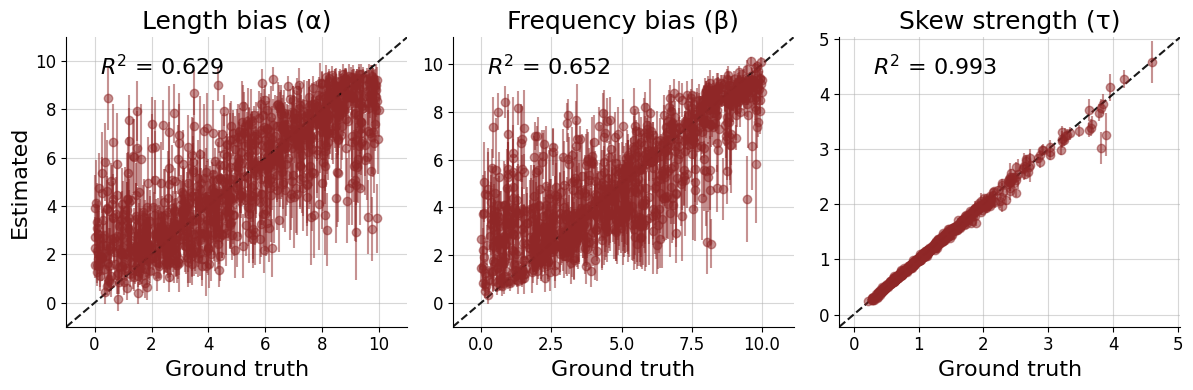

In [307]:
fig = diag.plot_recovery(post_samples[0:1000], prior_samples[0:1000], add_corr=False,
                         param_names=['Length bias (α)', 'Frequency bias (β)', 'Skew strength (τ)'],
                         )
# point_agg=np.mean, uncertainty_agg=np.std

In [308]:
post_samples.shape

(10000, 500, 3)

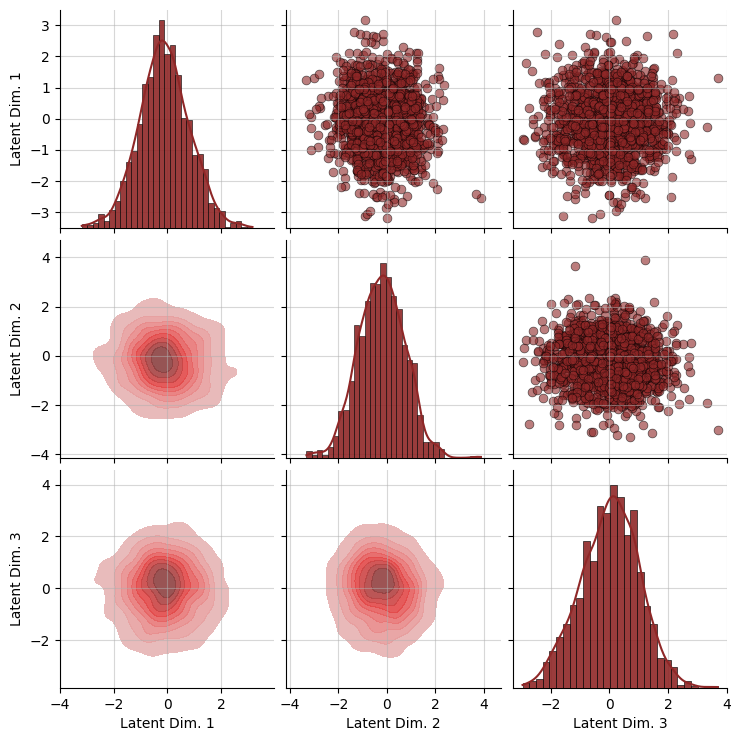

In [309]:
f = trainer.diagnose_latent2d()

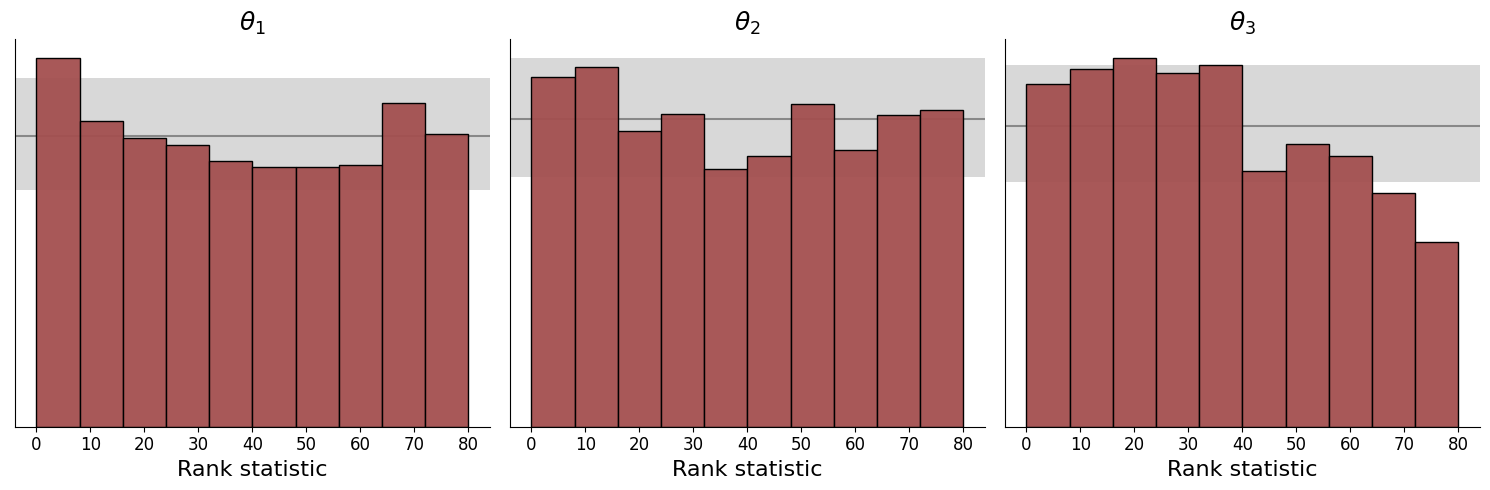

In [310]:
f = trainer.diagnose_sbc_histograms()

### 4. Posterior analysis

In [327]:
a = 10
b = 1
tau = 1

In [328]:
fake_dist = run_model_parallel([a], [b], [tau], 1)
# apply binning to each entry in sim_data using map
fake_dist = np.array(list(map(binning, fake_dist)))

In [329]:
obs_data = np.log1p(fake_dist[0])[np.newaxis, :, np.newaxis].astype(np.float32)

In [330]:
# Obtain 500 posterior draws given real data
post_samples_ = amortizer.sample({"summary_conditions": obs_data}, 10000)

# Undo standardization to get parameters on their original (unstandardized) scales
post_samples_ = prior_means + post_samples_ * prior_stds

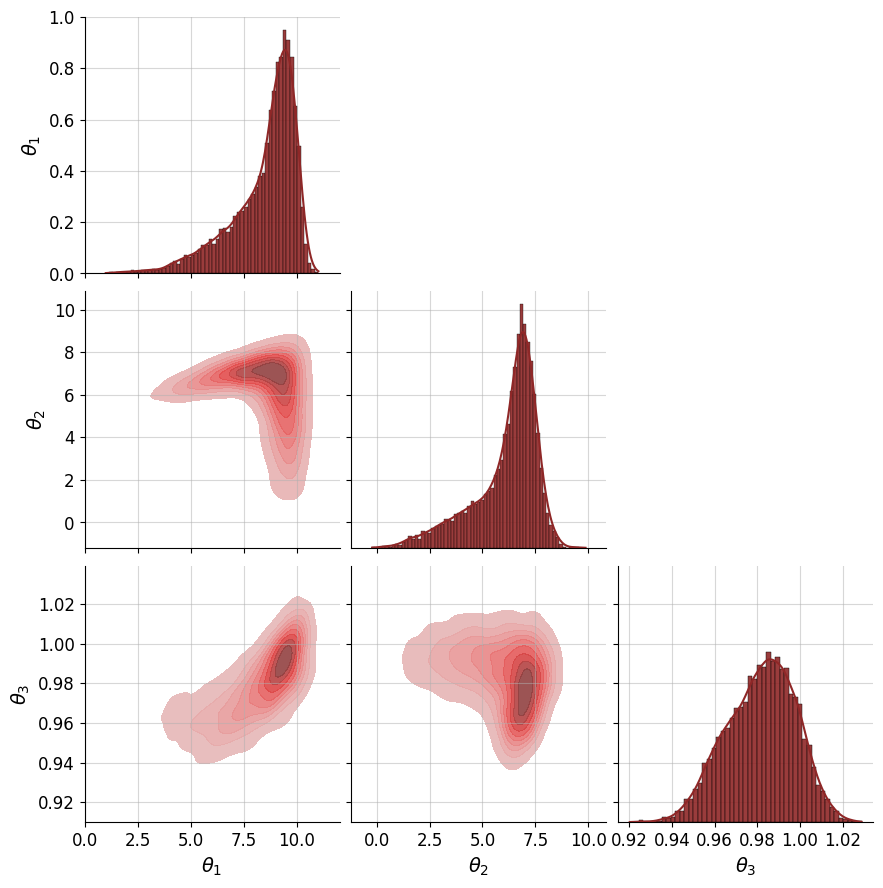

In [331]:
f = diag.plot_posterior_2d(post_samples_)

In [332]:
print(generate_latex_table(['Length bias (α)', 'Frequency bias (β)', 'Skew strength (τ)'], post_samples_))

\begin{tabular}{lrl}
\hline
 Parameter          &   Mean & HDI             \\
\hline
 Length bias (α)    &  8.45  & [ 5.098 10.504] \\
 Frequency bias (β) &  6.12  & [2.601 8.286]   \\
 Skew strength (τ)  &  0.982 & [0.949 1.01 ]   \\
\hline
\end{tabular}


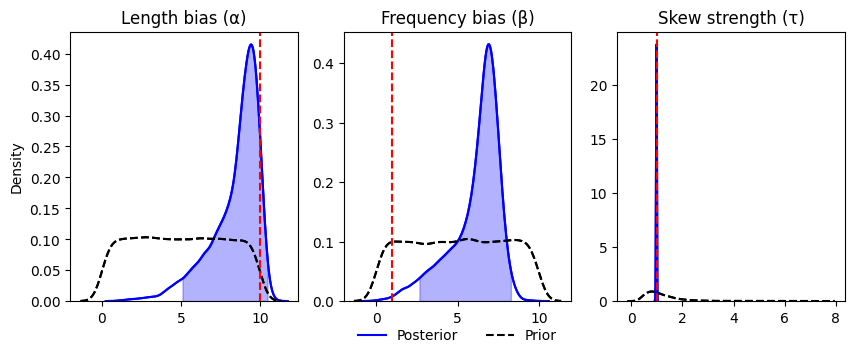

In [333]:
plot_posterior(post_samples_, ['Length bias (α)', 'Frequency bias (β)', 'Skew strength (τ)'], [a, b, tau], save=None)

In [334]:
# Perform PCA
pca = PCA(n_components=2, whiten=True)
pca_result = pca.fit_transform(train_data['sim_data'])

true_hist = obs_data.reshape(1, -1)
pca_true = pca.transform(true_hist)

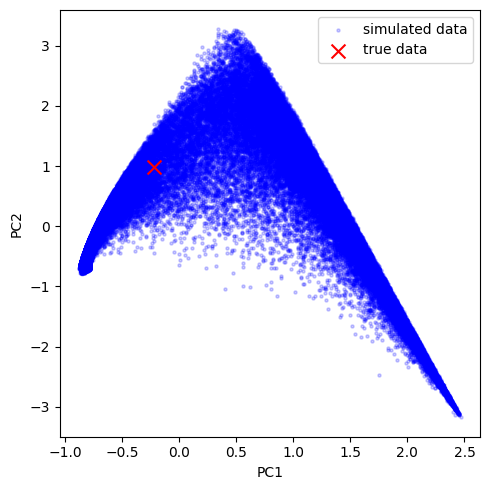

In [335]:
# Plot PCA
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(pca_result[:, 0], pca_result[:, 1], 
            s=5, color = 'blue', 
            alpha=0.2, label='simulated data')
plt.scatter(pca_true[:, 0], pca_true[:, 1],
             s=100, color='red', marker='x', 
             label='true data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.tight_layout()
plt.savefig('figures/pca.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [337]:
np.mean(post_samples_[:, 2]) # tau

0.9817747805045698

## Inference of alpha and beta knowing tau

### 1. Data generation

In [420]:
train_size_2 = 20000
test_size_2 = 2000
valid_size_2 = 2000

num_params = 2

In [421]:
training_params_2 = (np.random.uniform(0, 10, train_size_2), 
                   np.random.uniform(0, 10, train_size_2), 
                  [np.mean(post_samples_[:, 2])] * train_size_2)
testing_params_2 = (np.random.uniform(0, 10, test_size_2), 
                  np.random.uniform(0, 10, test_size_2), 
                 [np.mean(post_samples_[:, 2])] * test_size_2)
validation_params_2 = (np.random.uniform(0, 10, valid_size_2), 
                     np.random.uniform(0, 10, valid_size_2),
                    [np.mean(post_samples_[:, 2])] * valid_size_2)

In [422]:
training_data_2 = run_model_parallel(training_params_2[0], training_params_2[1], training_params_2[2], train_size_2)

KeyboardInterrupt: 

In [ ]:
testing_data_2 = run_model_parallel(testing_params_2[0], testing_params_2[1], testing_params_2[2], test_size_2)

In [ ]:
validation_data_2 = run_model_parallel(validation_params_2[0], validation_params_2[1], validation_params_2[2], valid_size_2)

In [ ]:
training_params_2 = np.vstack(training_params_2)
testing_params_2 = np.vstack(testing_params_2)
validation_params_2 = np.vstack(validation_params_2)

In [ ]:
# remove last array from params
training_params_2 = training_params_2[:-1]
testing_params_2 = testing_params_2[:-1]
validation_params_2 = validation_params_2[:-1]

In [ ]:
training_params_2.shape

(2, 100000)

In [ ]:
train_data_2 = {}
train_data_2["prior_non_batchable_context"] = None
train_data_2["prior_batchable_context"] = None
train_data_2["prior_draws"] = training_params_2[0, train_size_2].reshape(num_params, train_size_2).T
train_data_2["sim_non_batchable_context"] = None
train_data_2["sim_batchable_context"] = None
train_data_2["sim_data"] = np.array(training_data_2, dtype = float)


test_data_2 = {}
test_data_2["prior_non_batchable_context"] = None
test_data_2["prior_batchable_context"] = None
test_data_2["prior_draws"] = testing_params_2[0, test_size_2].reshape(num_params, test_size_2).T
test_data_2["sim_non_batchable_context"] = None
test_data_2["sim_batchable_context"] = None
test_data_2["sim_data"] = np.array(testing_data_2, dtype = float)

valid_data_2 = {}
valid_data_2["prior_non_batchable_context"] = None
valid_data_2["prior_batchable_context"] = None
valid_data_2["prior_draws"] = validation_params_2[0:valid_size_2].reshape(num_params, valid_size_2).T
valid_data_2["sim_non_batchable_context"] = None
valid_data_2["sim_batchable_context"] = None
valid_data_2["sim_data"] = np.array(validation_data_2, dtype = float)

IndexError: index 20000 is out of bounds for axis 1 with size 20000

In [ ]:
pickle.dump(train_data_2, open("data/train_data_1805_no_tau.pkl", "wb"))
pickle.dump(test_data_2, open("data/test_data_1805_no_tau.pkl", "wb"))
pickle.dump(valid_data_2, open("data/valid_data_1805_no_tau.pkl", "wb"))
# load results
# train_data_2 = pickle.load(open("data/train_data_1505_no_tau.pkl", "rb"))
# test_data_2 = pickle.load(open("data/test_data_1505_no_tau.pkl", "rb"))
# valid_data_2 = pickle.load(open("data/valid_data_1505_no_tau.pkl", "rb"))

In [ ]:
train_data_2["sim_data"] = np.array(list(map(binning, train_data_2["sim_data"])))
test_data_2["sim_data"] = np.array(list(map(binning, test_data_2["sim_data"])))
valid_data_2["sim_data"] = np.array(list(map(binning, valid_data_2["sim_data"])))

In [ ]:
train_data_2['prior_draws'].shape

(100000, 2)

In [ ]:
prior_means_2 = np.mean(train_data_2["prior_draws"], axis=0)
prior_stds_2 = np.std(train_data_2["prior_draws"], axis=0)

### 2. Model training

In [ ]:
num_params = 2
epochs = 100
batch_size = 32
learning_rate = 0.001

history_2, trainer_2, amortizer_2 = train_and_amortize(train_data_2, batch_size, test_data_2, 
                                                       epochs, num_params, 4, learning_rate, prior_means_2, prior_stds_2)

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!


ValueError: Dimensions 100000 and 20000 are not compatible

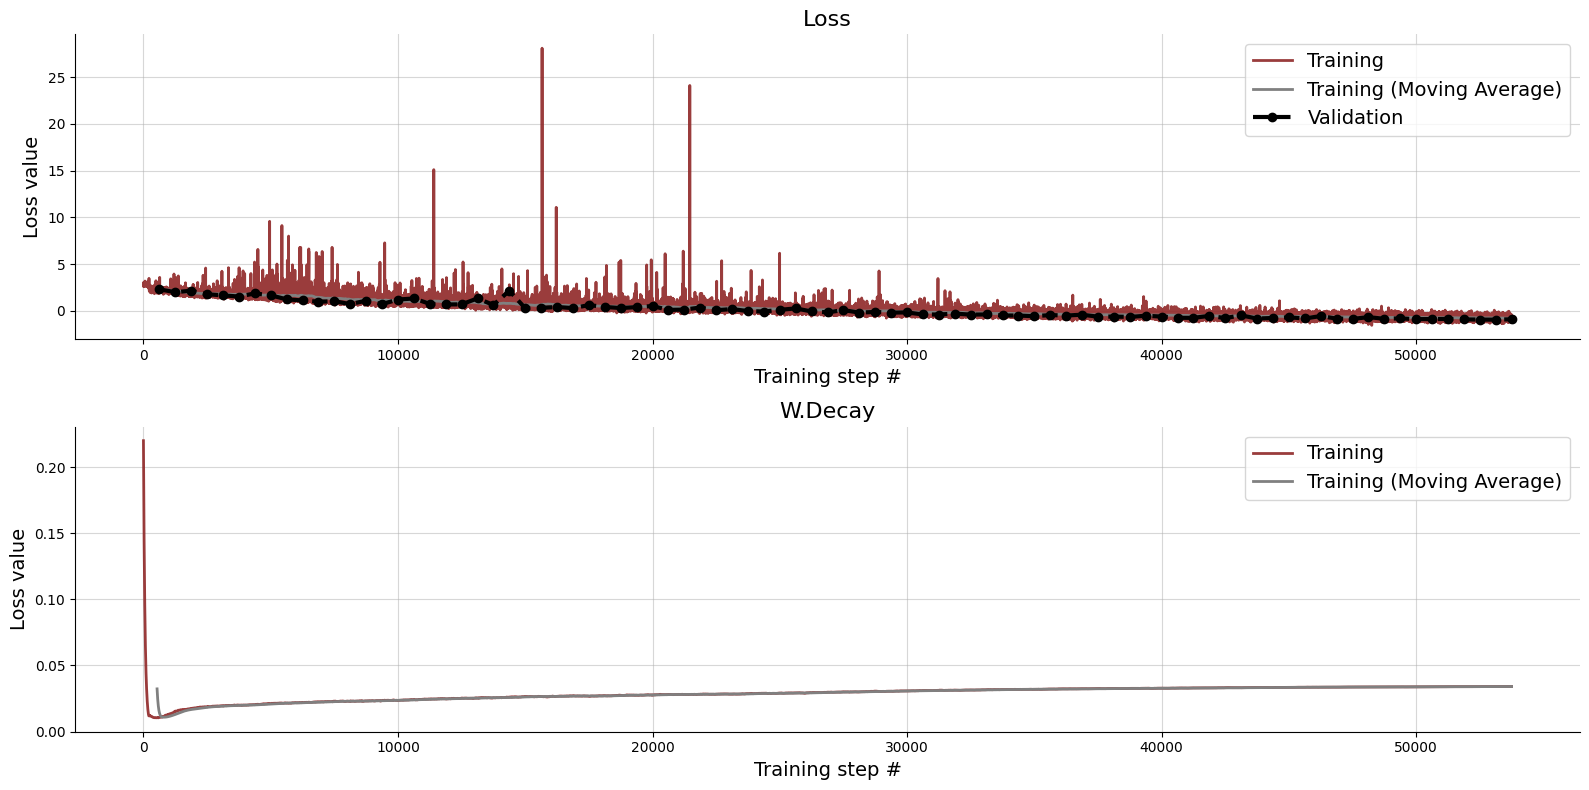

In [ ]:
f = diag.plot_losses(history_2["train_losses"], history_2["val_losses"], moving_average=True)

In [ ]:
# Generate some validation data
validation_sims = trainer_2.configurator(valid_data_2) 
prior_samples = validation_sims["parameters"] * prior_stds_2 + prior_means_2
# Generate posterior draws for all simulations
post_samples = amortizer_2.sample(validation_sims, n_samples=100)
post_samples = post_samples * prior_stds_2 + prior_means_2

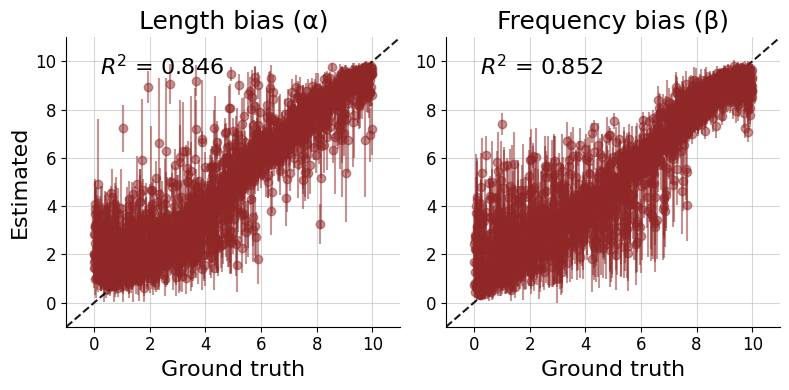

In [ ]:
fig = diag.plot_recovery(post_samples[0:2000], prior_samples[0:2000], add_corr=False,
                         param_names=['Length bias (α)', 'Frequency bias (β)'],
                         )
# point_agg=np.mean, uncertainty_agg=np.std

### 4. Posterior analysis

In [ ]:
a = 10
b = 1
tau = np.mean(post_samples_[:, 2])

In [ ]:
fake_dist = run_model_parallel([a], [b], [tau], 1)
fake_dist = np.array(list(map(binning, fake_dist)))

In [ ]:
obs_data = np.log1p(fake_dist[0])[np.newaxis, :, np.newaxis].astype(np.float32)

In [ ]:
# Obtain 500 posterior draws given real data
post_samples = amortizer_2.sample({"summary_conditions": obs_data}, 10000)

# Undo standardization to get parameters on their original (unstandardized) scales
post_samples = prior_means_2 + post_samples * prior_stds_2

In [ ]:
print(generate_latex_table(['Length bias (α)', 'Frequency bias (β)'], post_samples))

\begin{tabular}{lrl}
\hline
 Parameter          &   Mean & HDI             \\
\hline
 Length bias (α)    &  9.795 & [ 8.404 10.654] \\
 Frequency bias (β) &  6.69  & [4.345 8.446]   \\
\hline
\end{tabular}


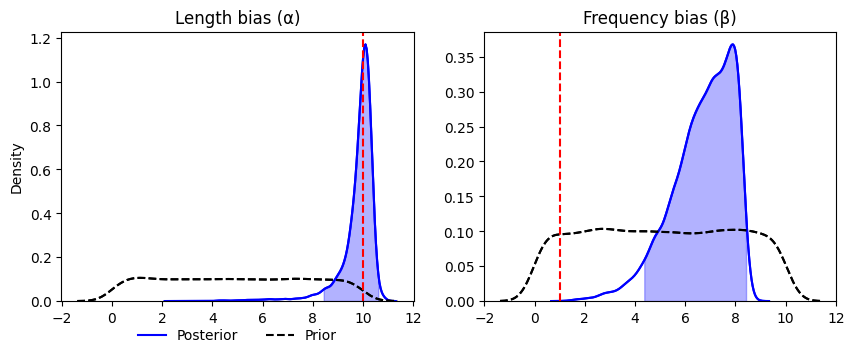

In [ ]:
plot_posterior(post_samples, ['Length bias (α)', 'Frequency bias (β)'], [a, b], save=None)